#### Task
. Взять датасет для классификации https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset, разбить на train-test-val (cat_filenames = glob(cat/*png), dog_filenames = glob(dog/*png), на треин 80%, на тест и валидацию по 10%), сохранить в pandas.DataFrame()).

2. Обучить resnet18 для классификации (подобрать порог, чтобы пресижн был 0.9). Разрешено использовать готовый чекпоинт, указав ссылку на него.

3. Сконвертировать модель в fp32 и fp16.

4. Собрать тритон ансамбль со следующими условиями:

   Пайплайн: препроцессинг -> [[инференс_fp16 -> постпроцессинг_fp16], [инференс_fp32 -> постпроцессинг_fp32]], где построцессинг_fp16 и построцессинг_fp32 считают скор и вердикт по одному и тому же трешхолду (иными словами здесь подразумевается общий препроцессинг и 2 параллельных инференса). На выход выдаются score_fp16, verdict_fp16, score_fp32, verdict_fp32.

5. Посчитать метрики для fp32 и fp16, изпользуя выходные значения ансамбля. Разрешено сокращать тестовый датасет сэмплом со сбалансированными классами на 200 объектов.

Результат:

В качестве результата ожидается собранный zip архив, в котором находятся:

1. Директории тритон-моделей для ансамбля (без файлов сборки докера или venv, упакуйте conda pack).

2. Jupyter Notebook с конвертацией модели (и обучением, если обучали сами).

3. Jupyter Notebook с подсчетом метрик для fp32 и fp16

### Download the dataset

In [9]:
!dir PetImages

 ’®¬ ў гбва®©бвўҐ D Ё¬ҐҐв ¬ҐвЄг Windows
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 8AB2-5F5C

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ D:\E\Copy\PyCharm\Hometask\ml_hard_models_2025\hw3\PetImages

12.03.2025  17:26    <DIR>          .
12.03.2025  17:26    <DIR>          ..
12.03.2025  17:26    <DIR>          Cat
12.03.2025  17:34    <DIR>          Dog
               0 д ©«®ў              0 Ў ©в
               4 Ї Ї®Є  370я934я710я272 Ў ©в бў®Ў®¤­®


In [4]:
import sys
print(sys.executable)
print(sys.version)

D:\E\Downloads\Anaconda\python.exe
3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [11]:
import pandas as pd
import glob
import random
from sklearn.model_selection import train_test_split

cat_filenames = glob.glob('PetImages/Cat/*.jpg')
dog_filenames = glob.glob('PetImages/Dog/*.jpg')

cat_labels = [0] * len(cat_filenames)  # 0 for cats
dog_labels = [1] * len(dog_filenames)  # 1 for dogs

all_filenames = cat_filenames + dog_filenames
all_labels = cat_labels + dog_labels
train_filenames, temp_filenames, train_labels, temp_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, random_state=666
)
val_filenames, test_filenames, val_labels, test_labels = train_test_split(
    temp_filenames, temp_labels, test_size=0.5, random_state=666
)

train_df = pd.DataFrame({'filename': train_filenames, 'label': train_labels})
val_df = pd.DataFrame({'filename': val_filenames, 'label': val_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'label': test_labels})

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 19998
Val: 2500
Test: 2500


### Fuck it, use a checkpoint (I ain't gonna train with cpu)
Here's the project I shall use: https://huggingface.co/hilmansw/resnet18-catdog-classifier
Also I AM aware I used validation for the threshold... either way it's a checkpoint I found so it's only natural to be 0.5

In [12]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("hilmansw/resnet18-catdog-classifier")
model = AutoModelForImageClassification.from_pretrained("hilmansw/resnet18-catdog-classifier")

D:\E\Downloads\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ulyan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
D:\E\Downloads\Anaconda\Lib\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtr

In [13]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from PIL import Image

def predict_probabilities(dataframe, processor, model, batch_size=32):
    probabilities = []
    model.eval()

    for i in tqdm(range(0, len(dataframe), batch_size), desc="Processing..."):
        batch_filenames = dataframe.loc[i:min(i + batch_size-1, len(dataframe)-1), "filename"].tolist()
        images = []
        for filename in batch_filenames:
            try:
                image = Image.open(filename).convert("RGB")
                images.append(image)
            except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
                print(f"Error loading image {filename}: {e}")
                probabilities.append(None)
                continue

        if images:
            try:
                inputs = processor(images=images, return_tensors="pt", padding=True, truncation=True)
                with torch.no_grad():
                    outputs = model(**inputs)
                    logits = outputs.logits
                    probabilities_batch = torch.softmax(logits, dim=1)[:, 1].tolist()
                    probabilities.extend(probabilities_batch)
            except Exception as e:
                print(f"Error processing batch: {e}")
                probabilities.extend([None] * len(images))

    return probabilities

In [32]:
processor.size

{'shortest_edge': 224}

In [35]:
filename = train_df.loc[0, "filename"]
image = Image.open(filename).convert("RGB")
inputs = processor(images=[image], return_tensors="pt", padding=True, truncation=True)
print(f'Input shape: {inputs["pixel_values"].shape}')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
print(f"Output shape: {logits.shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 2])


In [14]:
%%time
val_probabilities = predict_probabilities(val_df, processor, model)

Processing...: 100%|███████████████████████████████████████████████████████████████████| 79/79 [03:41<00:00,  2.81s/it]

CPU times: total: 6min 7s
Wall time: 3min 41s


In [16]:
val_probabilities = np.array(val_probabilities)

In [17]:
from sklearn.metrics import precision_score

def find_optimal_threshold(probabilities, labels, target_precision=0.9):
    sorted_indices = np.argsort(-probabilities)
    sorted_probabilities = probabilities[sorted_indices]
    sorted_labels = labels[sorted_indices]

    tp = 0
    fp = 0
    n_labels = len(labels)

    for i in range(n_labels):
        if sorted_labels[i] == 1:
            tp += 1
        else:
            fp += 1

        precision = tp / (tp + fp)

        if precision >= target_precision:
            optimal_threshold = sorted_probabilities[i]
            return optimal_threshold

    return 0.5

# probabilities = np.exp(all_logits[:, 1]) / np.sum(np.exp(all_logits), axis=1)
optimal_threshold = find_optimal_threshold(val_probabilities, val_df["label"], target_precision=0.9)
print(f"Optimal threshold with 0.9 precision: {optimal_threshold}")

Optimal threshold with 0.9 precision: 0.5


ROC AUC: 0.9928134354005987


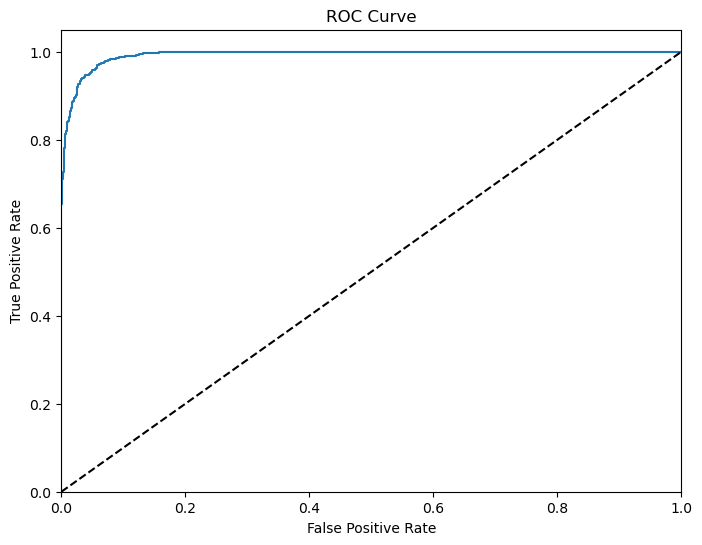

In [18]:
roc_auc = roc_auc_score(val_df["label"], val_probabilities)
print(f"ROC AUC: {roc_auc}")

fpr, tpr, thresholds = roc_curve(val_df["label"], val_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### Models to fp32 и fp16.

In [ ]:
import onnxruntime as ort


In [22]:
!dir model_repository

 ’®¬ ў гбва®©бвўҐ D Ё¬ҐҐв ¬ҐвЄг Windows
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 8AB2-5F5C

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ D:\E\Copy\PyCharm\Hometask\ml_hard_models_2025\hw3\model_repository

12.03.2025  21:08    <DIR>          .
12.03.2025  21:08    <DIR>          ..
12.03.2025  21:04    <DIR>          resnet_concat_ensemble
12.03.2025  21:04    <DIR>          resnet_concat_preprocessing
12.03.2025  21:04    <DIR>          resnet_ensemble
12.03.2025  21:07    <DIR>          resnet_model_fp16
12.03.2025  21:08    <DIR>          resnet_model_fp32
12.03.2025  21:04    <DIR>          resnet_postprocessing
12.03.2025  21:04    <DIR>          resnet_preprocessing
12.03.2025  21:04    <DIR>          resnet_preprocessing_v2
12.03.2025  19:09             8я200 triton_model_client.py
               1 д ©«®ў          8я200 Ў ©в
              10 Ї Ї®Є  370я887я352я320 Ў ©в бў®Ў®¤­®


In [36]:
PREFIX_MODELS = "model_repository"

In [41]:
import os
import onnx

dummy_image = torch.randn(3, 224, 224)
dummy_image = (dummy_image - dummy_image.min()) / (dummy_image.max() - dummy_image.min())
dummy_image = Image.fromarray(np.uint8(dummy_image * 255).transpose(1, 2, 0))
dummy_input = processor(images=dummy_image, return_tensors="pt")
dummy_input = dummy_input["pixel_values"]

input_names = ["input"]
output_names = ["output"]

dynamic_axes = {
    "input": {0: "batch_size"},
    "output": {0: "batch_size"},
}

onnx_path_fp32 = os.path.join(PREFIX_MODELS, "resnet_model_fp32", "1", "model.onnx")
os.makedirs(os.path.dirname(onnx_path_fp32), exist_ok=True)

model.eval()
with torch.no_grad():
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path_fp32,
        opset_version=13,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axes,
        do_constant_folding=True,
        verbose=False,
    )

onnx_model_fp32 = onnx.load(onnx_path_fp32)
onnx.checker.check_model(onnx_model_fp32)
print(f"FP32 ONNX model exported to: {onnx_path_fp32}")

FP32 ONNX model exported to: model_repository\resnet_model_fp32\1\model.onnx


In [44]:
from onnxconverter_common import float16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dummy_input = dummy_input.to(device)

onnx_path_fp16 = os.path.join(PREFIX_MODELS, "resnet_model_fp16", "1", "model.onnx")
os.makedirs(os.path.dirname(onnx_path_fp16), exist_ok=True)

onnx_model_fp16 = float16.convert_float_to_float16(onnx_model_fp32)
onnx.save(onnx_model_fp16, onnx_path_fp16)
onnx.checker.check_model(onnx_model_fp16)
onnx_path_fp16

D:\E\Downloads\Anaconda\Lib\site-packages\onnxconverter_common\float16.py:43: UserWarning: the float32 number 8.522016349426747e-17 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
D:\E\Downloads\Anaconda\Lib\site-packages\onnxconverter_common\float16.py:53: UserWarning: the float32 number -1.0364713365121326e-16 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
D:\E\Downloads\Anaconda\Lib\site-packages\onnxconverter_common\float16.py:53: UserWarning: the float32 number -1.6564982274758222e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
D:\E\Downloads\Anaconda\Lib\site-packages\onnxconverter_common\float16.py:43: UserWarning: the float32 number 1.0156333239697002e-12 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated t

'model_repository\\resnet_model_fp16\\1\\model.onnx'

### Try to connect (no)